<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using pycaret</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github:pycaret](https://github.com/pycaret)
- [TWS: PyCaret 2.2 is here — What’s new?](https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b)
- [pycaret-demo-queens/PyCaret 2 Classification.ipynb](https://github.com/pycaret/pycaret-demo-queens/blob/main/PyCaret%202%20Classification.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

pycaret 2.2.0
numpy   1.19.4
seaborn 0.11.0
pandas  1.1.5



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [5]:
def compare_new_models(name,desc,mean_row,df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_arr: np.ndarray
        The mean row.
        e.g. 
        df_res = pyc.pull()
        mean_row = df_res.loc['Mean']
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision
                                F1, Kappa

    Returns:
       Pandas Dataframe.

    """
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))
    
    if show:
        display(df_style)
    
    return df_eval

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/processed/train_cleaned.csv'
path_data_test = '../data/processed/test_cleaned.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/train_cleaned.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/test_cleaned.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 39)
(1409, 39)


Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0          0              0        1           0      36             1   
1          1              0        0           0      10             1   
5632       0              0        1           1      68             1   
5633       1              0        0           0      69             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 2                1               2             2   
1                 0                0               2             0   
5632              2                1               0             2   
5633              2                2               1             1   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    2            2            0                2         2   
1                    0            2            2                0         0   
5632                 0            2            2                2         2   
5633                 1            1            1                1         2   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
0                    1              1          106.05       3834.40      0   
1                    0              1           62.25        612.95      0   
5632                 1              1          103.75       7039.45      0   
5633                 0              1           23.95       1713.10      0   

      Contract_Month-to-month  NoSeniorCitizen_Contract_Month-to-month  \
0                           1                                        0   
1                           0                                        1   
5632                        1                                        0   
5633                        1                                        0   

      PaymentMethod0_Contract_Month-to-month0  InternetService_Fiber optic  \
0                                           0                            0   
1                                           0                            1   
5632                                        0                            0   
5633                                        0                            1   

      StreamingTV_NoInternetService  No_OB_DP_TS  TotalServices  \
0                                 1            1              2   
1                                 1            1              1   
5632                              1            1              2   
5633                              0            1              7   

      SenCit_Dependents  Partner_Dependents  SenCit_Partner  SenCit_Contract  \
0                     0                   1               1                2   
1                     0                   0               0                0   
5632                  1                   2               1                2   
5633                  0                   0               0                2   

      SenCit_TechSupport  SenCit_PayMeth  Contract_mean_totCharges  \
0                      2               1               3683.643192   
1                      2               1               1370.923131   
5632                   2               1               3683.643192   
5633                   1               1               3683.643192   

      Contract_totCharges_diff  PayMeth_mean_monthCharges  \
0                   150.756808                  66.703657   
1                  -757.973131                  66.703657   
5632               3355.806808                  66.703657   
5633              -1970.543192                  66.703657   

      PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  
0                     39.346343           3                   0  
1                     -4.453657           0                   0  
5632                  37.046343           5                   0  
5633                 -42.753657           5                   0

In [8]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
# check for nans
df_train.isna().sum().sum()

0

<a id="" ></a>

<h1>  Modelling Pycaret </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [10]:
import pycaret
import pycaret.classification as pyc

<a id="" ></a>

<h1>  Pycaret Setup</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.setup(
    data: pandas.core.frame.DataFrame,
    target: str,
    train_size                    = 0.7,
    test_data                     = None,
    preprocess                    = True,
    imputation_type               = 'simple',
    iterative_imputation_iters    = 5,
    categorical_features          = None,
    categorical_imputation        = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features              = None,
    high_cardinality_features     = None,
    high_cardinality_method       = 'frequency',
    numeric_features              = None,
    numeric_imputation            = 'mean',
    numeric_iterative_imputer     = 'lightgbm',
    date_features                 = None,
    ignore_features               = None,
    normalize                     = False,
    normalize_method              = 'zscore',
    transformation                = False,
    transformation_method         = 'yeo-johnson',
    handle_unknown_categorical    = True,
    unknown_categorical_method    = 'least_frequent',
    pca                           = False,
    pca_method                    = 'linear',
    pca_components                = None,
    ignore_low_variance           = False,
    combine_rare_levels           = False,
    rare_level_threshold          = 0.1,
    bin_numeric_features          = None,
    remove_outliers               = False,
    outliers_threshold            = 0.05,
    remove_multicollinearity      = False,
    multicollinearity_threshold   = 0.9,
    remove_perfect_collinearity   = True,
    create_clusters               = False,
    cluster_iter                  = 20,
    polynomial_features           = False,
    polynomial_degree             = 2,
    trigonometry_features         = False,
    polynomial_threshold          = 0.1,
    group_features                = None,
    group_names                   = None,
    feature_selection             = False,
    feature_selection_threshold   = 0.8,
    feature_selection_method      = 'classic',
    feature_interaction           = False,
    feature_ratio                 = False,
    interaction_threshold         = 0.01,
    fix_imbalance                 = False,
    fix_imbalance_method          = None,
    data_split_shuffle            = True,
    data_split_stratify           = False,
    fold_strategy                 = 'stratifiedkfold',
    fold                          = 10,
    fold_shuffle                  = False,
    fold_groups                   = None,
    n_jobs                        = -1,
    use_gpu                       = False,
    custom_pipeline               = None,
    html                          = True,
    session_id                    = None,
    log_experiment                = False,
    experiment_name               = None,
    log_plots                     = False,
    log_profile                   = False,
    log_data                      = False,
    silent                        = False,
    verbose                       = True,
    profile                       = False,
    profile_kwargs                = None,
)

```

In [11]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [12]:
# %%capture
exp = pyc.setup(df_train,'Churn',
                train_size=0.8,
                session_id=SEED,
                use_gpu=USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False
                )

# use silent = True to check inferred datatypes
# then assign numeric and categorical features yourself.
#
# if sampling = False, 100% of data is used and its too slow
# if sampling = True, we need to enter number eg. 0.3 ourself.

"""
Here, we have data < 25k rows, so I have chosen not to use sampling.

""";

Description             Value
0                               session_id               100
1                                   Target             Churn
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data        (5634, 39)
5                           Missing Values             False
6                         Numeric Features                 6
7                     Categorical Features                32
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set        (4507, 60)
12                    Transformed Test Set        (1127, 60)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test              True
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              8536
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                           Fix Imbalance             False
57                    Fix Imbalance Method             SMOTE

In [13]:
pyc.models(internal=True)[['Name', 'GPU Enabled']]

# google colab does not support cuml and thereby sklearn models
# we need to run blazingsql notebooks (not colab) to use cuml models.

Name  GPU Enabled
ID                                                        
lr                        Logistic Regression        False
knn                    K Neighbors Classifier        False
nb                                Naive Bayes        False
dt                   Decision Tree Classifier        False
svm                       SVM - Linear Kernel        False
rbfsvm                    SVM - Radial Kernel        False
gpc               Gaussian Process Classifier        False
mlp                            MLP Classifier        False
ridge                        Ridge Classifier        False
rf                   Random Forest Classifier        False
qda           Quadratic Discriminant Analysis        False
ada                      Ada Boost Classifier        False
gbc              Gradient Boosting Classifier        False
lda              Linear Discriminant Analysis        False
et                     Extra Trees Classifier        False
xgboost             Extreme Gradient Boosting         True
lightgbm      Light Gradient Boosting Machine         True
catboost                  CatBoost Classifier        False
Bagging                    Bagging Classifier        False
Stacking                  Stacking Classifier        False
Voting                      Voting Classifier        False
CalibratedCV         Calibrated Classifier CV        False

<a id="" ></a>

<h1>  Comparing Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>



Comparing All Models
- compare using stratified cross validation for metric evaluation.
- shows average metrics for score grid for 10 fold cross-validation
- default sorting is `accuracy`


```python
pyc.compare_models(
    include          = None,
    exclude          = None,
    fold             = None,
    round            = 4,
    cross_validation = True,
    sort             = 'Accuracy',
    n_select         = 1,
    budget_time      = None,
    turbo            = True,
    errors           = 'ignore',
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
) 
```


In [14]:
# pyc.compare_models?

In [15]:
pyc.get_metrics().index

Index(['acc', 'auc', 'recall', 'precision', 'f1', 'kappa', 'mcc'], dtype='object', name='ID')

In [16]:
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pyc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7f513ac8dbf8>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

<a id="" ></a>

<h1>  Create Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Estimator                   Abbreviated String     Original Implementation 
---------                   ------------------     -------------------------------
Logistic Regression         'lr'                   linear_model.LogisticRegression
K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
Naives Bayes                'nb'                   naive_bayes.GaussianNB
Decision Tree               'dt'                   tree.DecisionTreeClassifier
SVM (Linear)                'svm'                  linear_model.SGDClassifier
SVM (RBF)                   'rbfsvm'               svm.SVC
Gaussian Process            'gpc'                  gaussian_process.GPC
Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
Ridge Classifier            'ridge'                linear_model.RidgeClassifier
Random Forest               'rf'                   ensemble.RandomForestClassifier
Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
CatBoost Classifier         'catboost'             https://catboost.ai
```

```python
pyc.create_model(
    estimator,
    fold             = None,
    round            = 4,
    cross_validation = True,
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
    **kwargs,
)
```

In [17]:
model_name = 'xgboost'
model = pyc.create_model(model_name,verbose=False)

mean_row = pyc.pull().loc['Mean'].values
df_eval = compare_new_models(model_name,'default',mean_row,sort='Recall',df_eval=None)

<a id="" ></a>

<h1>  Hyperparameter Tuning</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.tune_model(
    estimator,
    fold                     = None,
    round                    = 4,
    n_iter                   = 10,
    custom_grid              = None,
    optimize                 = 'Accuracy',
    custom_scorer            = None,
    search_library           = 'scikit-learn', # 'scikit-optimize', 'tune-sklearn','optuna'
    search_algorithm         = None, # 'scikit-learn', 'scikit-optimize', 'tune-sklearn', 'optuna'
    early_stopping           = False, # 'asha','hyperband','median' 
    early_stopping_max_iters = 10,
    choose_better            = False,
    fit_kwargs               = None,
    groups                   = None,
    return_tuner             = False,
    verbose                  = True,
    tuner_verbose            = True,
    **kwargs,
)
```

In [18]:
%%capture
model_tuned1 = pyc.tune_model(model,n_iter=100,search_library='tune-sklearn',
                              fold=5,optimize='Recall',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,tune-sklearn,n_iter=100'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

In [19]:
# %%capture
# model_tuned2 = pyc.tune_model(model,n_iter=500,search_library='optuna',
#                               fold=5,optimize='Recall',verbose=False)
# mean_row = pyc.pull().loc['Mean']

# desc = 'tuned,optuna,n_iter=500'
# df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)


# This is BAD, it gave me Recall = 1, too much overfitting
#              everything is classified as not-churn
#              USE AUC instead of Recall

In [71]:
# %%capture
# model_tuned_AUC = pyc.tune_model(model,n_iter=500,search_library='optuna',
#                               fold=5,optimize='AUC',verbose=False)
# mean_row = pyc.pull().loc['Mean']

# desc = 'tuned,optuna,n_iter=500,optimize=AUC'
# df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

# THIS GAVE ME WORSE RESULT THAN F1

In [20]:
%%capture
model_tuned_F1 = pyc.tune_model(model,n_iter=500,search_library='optuna',
                               fold=5,optimize='F1',verbose=False)
mean_row = pyc.pull().loc['Mean']

desc = 'tuned,optuna,n_iter=500,optimize=F1'
df_eval = compare_new_models(model_name,desc,mean_row,sort='Recall',df_eval=df_eval)

In [72]:
df_eval

Model                           Description  ...     MCC  LogLoss
0  xgboost               tuned,optuna,n_iter=500  ...  0.0000  25.3740
1  xgboost   tuned,optuna,n_iter=500,optimize=F1  ...  0.5082   7.6097
2  xgboost         tuned,tune-sklearn,n_iter=100  ...  0.4821   7.9545
3  xgboost               tuned,optuna,n_iter=500  ...  0.4966   6.4755
4  xgboost  tuned,optuna,n_iter=500,optimize=AUC  ...  0.4966   6.4755
5  xgboost                               default  ...  0.4319   7.3568

[6 rows x 10 columns]

In [95]:
model_best = model_tuned_F1

In [96]:
# after selecting best model, delete unwanted models
import gc

try: 
    del model_tuned1
except:
    pass

gc.collect()

8064

<a id="" ></a>

<h1>  Model Evaluation (Training )</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Name                        Abbreviated String     
---------                   ------------------ 
Area Under the Curve         'auc'              
Discrimination Threshold     'threshold'
Precision Recall Curve       'pr'
Confusion Matrix             'confusion_matrix'
Class Prediction Error       'error'
Classification Report        'class_report'
Decision Boundary            'boundary'
Recursive Feat. Selection    'rfe' 
Learning Curve               'learning'
Manifold Learning            'manifold'
Calibration Curve            'calibration'
Validation Curve             'vc' 
Dimension Learning           'dimension'
Feature Importance           'feature'
Model Hyperparameter         'parameter'
```

```python
pyc.plot_model(
    estimator,
    plot           = 'auc',
    scale          = 1,
    save           = False,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False,
    verbose        = True,
)
```

In [97]:
# pyc.plot_model gives one by one plot, use 
# pyc.evaluate_model to get all the plots.

# evaluate model (click on buttons)
pyc.evaluate_model(model_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id="" ></a>

<h1>  Model Interpretation of Tree Methods (Training) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.interpret_model(
    estimator,
    plot           = 'summary',
    feature        = None,
    observation    = None,
    use_train_data = False,
    **kwargs,
)
```

- not supported models: logistic regression, nb
- supported models : rf, xgboost, lightgbm, catboost, dt, et

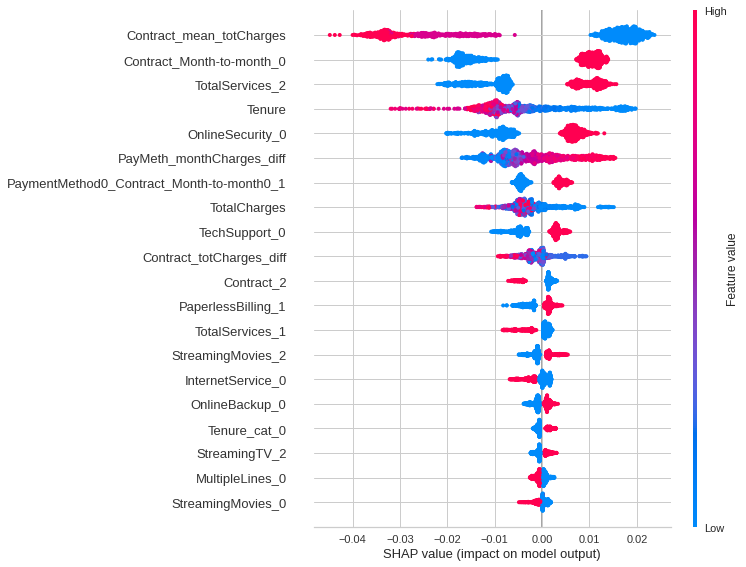

In [98]:
# interpret_model: SHAP
pyc.interpret_model(model_best)

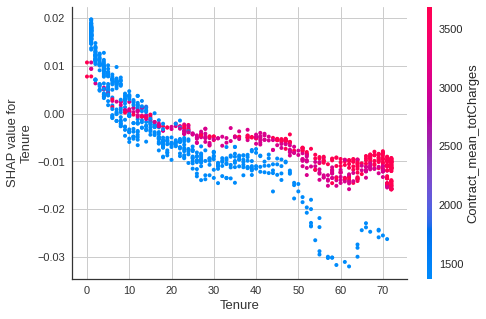

In [99]:
# interpret model : Correlation
pyc.interpret_model(model_best,plot='correlation')

In [100]:
# interpret model : Reason
pyc.interpret_model(model_best,plot='reason',observation=12)

<a id="" ></a>

<h1>  Finalize model (Fit whole train data) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.finalize_model(
    estimator,
    fit_kwargs = None,
    group      = None,
    model_only = True,
)

Docstring:
This function trains a given estimator on the entire dataset including the 
holdout set.
```

In [101]:
model_final = pyc.finalize_model(model_best)
print(model_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5381221355651895, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.00037329487864589035, max_delta_step=0,
              max_depth=6, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=154, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              random_state=100, reg_alpha=0.08511412277758966,
              reg_lambda=0.00029018987747839127,
              scale_pos_weight=2.74298154771426, subsample=0.39283675657061895,
              tree_method='gpu_hist', use_label_encoder=True,
              validate_parameters=1, verbosity=0)


<a id="" ></a>

<h1>  Model Persistence </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.save_model(
    model,
    model_name,
    model_only = False,
    verbose    = True,
)
```

In [102]:
if 'google.colab' in sys.modules:
    h = ''
else:
    h = "../models/"

In [103]:
# save the model
# path_model_final = h + 'model_final_xgb_pycaret'
# pyc.save_model(model_final, path_model)

In [104]:
# load model
# model_final_loaded = pyc.load_model(path_model_final)

In [105]:
# save entire experiment
# pyc.save_experiment( h + "experiment_may31_2020")
# saved_experiment = pyc.load_experiment( h+ 'experiment_may31_2020')

# this fails for some reason.

<a id="" ></a>

<h1>  Model Prediction </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.predict_model(
    estimator,
    data                  = None,
    probability_threshold = None,
    encoded_labels        = False,
    round                 = 4,
    verbose               = True,
) -> pandas.core.frame.DataFrame
```

In [106]:
# pyc.predict_model?

In [107]:
df_test.iloc[:5,-5:]

Contract_totCharges_diff  ...  MonthlyCharges_cat
0              -1313.937095  ...                   0
1               1902.661398  ...                   0
2               1880.912905  ...                   0
3              -3545.288602  ...                   0
4              -3415.038602  ...                   0

[5 rows x 5 columns]

In [108]:
df_preds = pyc.predict_model(model_best,df_test)
df_preds.iloc[:5,-5:]

PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  Label   Score
0                 -18.837658           0                   0      1  0.5055
1                  32.462342           4                   0      0  0.5176
2                  40.285135           2                   0      1  0.5096
3                 -44.214865           1                   0      0  0.5276
4                 -47.387658           1                   0      0  0.5252

<a id="" ></a>

<h1>  Model Evaluation on Test Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [109]:
df_test.iloc[-5:,-5:]

Contract_totCharges_diff  ...  MonthlyCharges_cat
1404               -859.687095  ...                   0
1405              -1152.769579  ...                   0
1406               -218.037095  ...                   0
1407                -77.487095  ...                   0
1408               -367.987095  ...                   0

[5 rows x 5 columns]

In [110]:
df_preds = pyc.predict_model(model_final,df_test)
df_preds.iloc[-5:,-5:]

PayMeth_monthCharges_diff  Tenure_cat  MonthlyCharges_cat  Label   Score
1404                  16.585135           0                   0      1  0.5156
1405                 -19.764865           3                   0      0  0.5135
1406                   6.085135           1                   0      1  0.5087
1407                  30.735135           1                   0      1  0.5170
1408                  -2.787658           1                   0      0  0.5031

In [111]:
ytest = df_preds[target_name].to_numpy().ravel()
yprobs = df_preds['Score'].to_numpy().ravel()
ypreds = df_preds['Label'].to_numpy().ravel()

yprobs2d = np.c_[1-yprobs,yprobs]

In [112]:
import sklearn.metrics as skmetrics

report = f"""
Accuracy  : {skmetrics.accuracy_score(ytest,ypreds):.4f}
Precision : {skmetrics.precision_score(ytest,ypreds):.4f}
Recall    : {skmetrics.recall_score(ytest,ypreds):.4f}
F1-score  : {skmetrics.f1_score(ytest,ypreds):.4f}
AUC       : {skmetrics.roc_auc_score(ytest,ypreds):.4f}
"""
print(report)

print(skmetrics.classification_report(ytest,ypreds))
# look at the value of recall for 1. It must be nearer to 1.

print(skmetrics.confusion_matrix(ytest,ypreds))


Accuracy  : 0.7580
Precision : 0.5303
Recall    : 0.7727
F1-score  : 0.6289
AUC       : 0.7627

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

[[779 256]
 [ 85 289]]


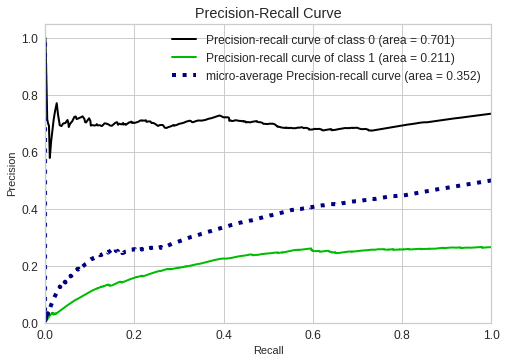

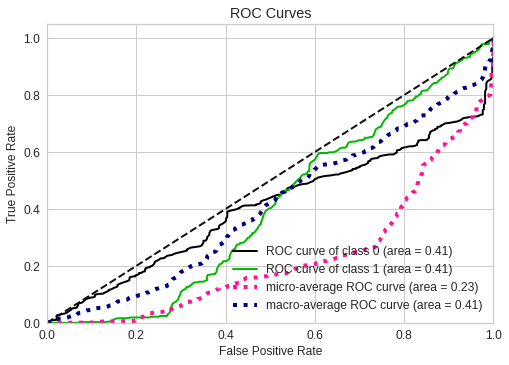

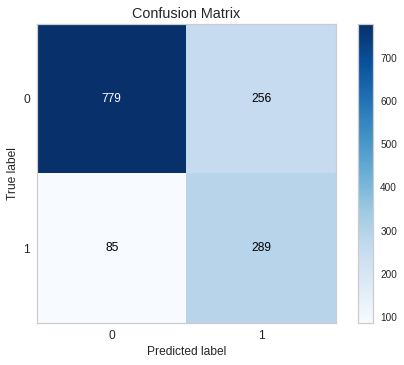

In [113]:
import scikitplot.metrics as skpmetrics

skpmetrics.plot_precision_recall(ytest,yprobs2d)
skpmetrics.plot_roc_curve(ytest,yprobs2d)
skpmetrics.plot_confusion_matrix(ytest,ypreds)

In [114]:
"""
There are total  374 churn cases in test dataset (20% of full data with seed=100)
Out of which only 289 are correctly classified.

This is great an improvement.
The dataset it highly imbalanced. The dumb classifier will classify
everything as non-churn.
""";

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [115]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 2 hr 17 min 3 secs
